# Global Income Prediction

## Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,f1_score

## Data Preparation

In [3]:
# CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
# DATA_DIR = os.path.join(CURRENT_DIR, 'data')
TRAIN_DATA_FILE = os.path.join('/data', 'adult.data')

In [4]:
print(TRAIN_DATA_FILE)

/data/adult.data


In [5]:
# Organize data into respective categories
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [6]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

In [7]:
 # data = clean_dataset(read_dataset(TRAIN_DATA_FILE))


 # print("Percent of the positive classes in the training data: {:.2%}".format(np.mean(data.income_class)))

In [8]:
# Alternatively, we can upload adult.data onto colab and run the following code
data = clean_dataset(pd.read_csv(
        'adult.data',
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    ))

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29096 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             29096 non-null  int64   
 1   workclass       27464 non-null  category
 2   education       29096 non-null  category
 3   education_num   29096 non-null  int64   
 4   marital_status  29096 non-null  category
 5   occupation      27457 non-null  category
 6   relationship    29096 non-null  category
 7   race            29096 non-null  category
 8   sex             29096 non-null  category
 9   capital_gain    28938 non-null  float64 
 10  capital_loss    29096 non-null  int64   
 11  hours_per_week  29096 non-null  int64   
 12  native_country  28516 non-null  category
 13  income_class    29096 non-null  int64   
dtypes: category(8), float64(1), int64(5)
memory usage: 1.8 MB


In [10]:
data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,Cuba,0


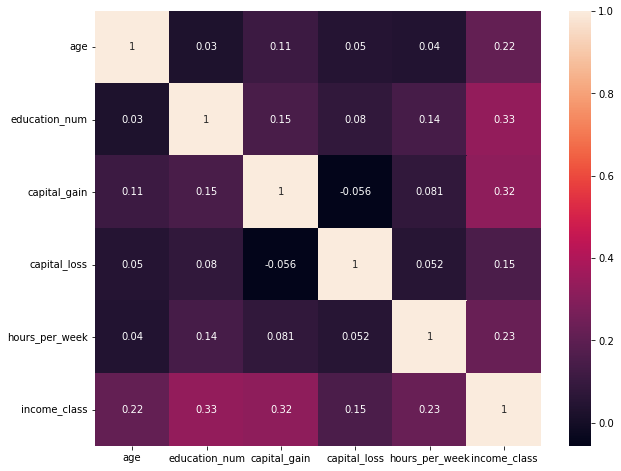

In [11]:
# Generate heap map for df
fig, ax = plt.subplots(figsize=(10, 8))
dataplot = sns.heatmap(data.corr(),annot=True)
plt.show()

## Linear Model

<div>With Only numerical features</div>
<div> We can start off with only a couple of numerical features, which is easy to apply and don't require extra data transformations.
</div>


### Logistic Regression with 3 features

In [12]:
# Select 3 numerical features for our model
features = [
    'age',
    'education_num',
    'hours_per_week'
]

In [13]:
# data processing - dropping other data column

X1 = data.copy(deep=True)

for i in X1:
    if i not in features:
        # print(i)
        X1 = X1.drop([i], axis =1)
        
y1 = data.income_class
X1

,age,education_num,hours_per_week
0,39,13,40
1,50,13,13
2,38,9,40
3,53,7,40
4,28,13,40
...,...,...,...
32554,53,14,40
32555,22,10,40
32556,27,12,38
32558,58,9,40


In [14]:
#perform train and test data splits using y and X
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=1)
# confirm we have the right number of train and test data set
print( len(X_train), len(X_test), len(y_train), len(y_test) )

23276 5820 23276 5820


In [15]:
# Standardize data to make models coeficients interpratable. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
logistic_regression = LogisticRegression()

# instantiate Logistic Regression model
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [17]:
# Predict the results
pred = logistic_regression.predict(X_test)


In [18]:
print('Coefficients: \n', logistic_regression.coef_)

Coefficients: 
 [[0.58350974 0.87783566 0.52974063]]


In [19]:
# Calculate and print R^2 and MAE
print( 'R^2:', r2_score(y_test, pred))
print( 'MAE:', mean_absolute_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('\n')

R^2: -0.15713470319634704
MAE: 0.2154639175257732
RMSE: 0.46418091034183345
MSE: 0.2154639175257732




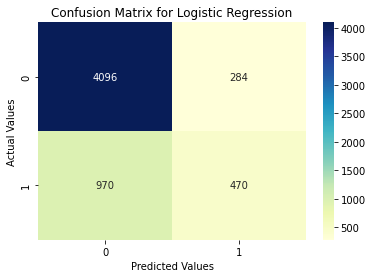

In [20]:
plt.title('Confusion Matrix for Logistic Regression')
cm_lr = confusion_matrix(y_test,pred)
sns.heatmap(cm_lr,annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [21]:
print('\nClassification Report of Logistic Regression\n')
print(classification_report(y_test, pred))

print("Precision score of Logistic Regression:", precision_score(y_test, pred, average = 'weighted'))
print("Recall score of Logistic Regression:", recall_score(y_test, pred, average = 'weighted'))
print("F1 score of Logistic Regression:", f1_score(y_test, pred, average = 'weighted'))


Classification Report of Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4380
           1       0.62      0.33      0.43      1440

    accuracy                           0.78      5820
   macro avg       0.72      0.63      0.65      5820
weighted avg       0.76      0.78      0.76      5820

Precision score of Logistic Regression: 0.76270840373719
Recall score of Logistic Regression: 0.7845360824742268
F1 score of Logistic Regression: 0.7586752856156528


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


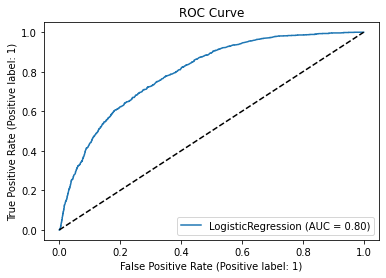

In [22]:
from sklearn.metrics import plot_roc_curve
# Plot ROC curve
plot_roc_curve(logistic_regression, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

### Logistic Regression Model with 5 Features

In [23]:
# Select 5 Features for aour prediciton model.
features = [
    'age',
    'education_num',
    'hours_per_week',
    'capital_gain',
    'capital_loss'
]

In [24]:
# data processing - dropping other data column

X2 = data.copy(deep=True)

for i in X2:
    if i not in features:
        # print(i)
        X2 = X2.drop([i], axis =1)
        
y2 = data.income_class
X2

,age,education_num,capital_gain,capital_loss,hours_per_week
0,39,13,2174.0,0,40
1,50,13,0.0,0,13
2,38,9,0.0,0,40
3,53,7,0.0,0,40
4,28,13,0.0,0,40
...,...,...,...,...,...
32554,53,14,0.0,0,40
32555,22,10,0.0,0,40
32556,27,12,0.0,0,38
32558,58,9,0.0,0,40


In [25]:
# Handle N.A data type - replacing with 0. 
X2 = X2[features].fillna(0).astype(float)

In [26]:
#perform train and test data splits using y and X
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=1)
# confirm we have the right number of train and test data set
print( len(X_train), len(X_test), len(y_train), len(y_test) )

23276 5820 23276 5820


In [27]:
# Standardize data to make models coeficients interpratable. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logistic_regression = LogisticRegression()

# instantiate Logistic Regression model
logistic_regression.fit(X_train, y_train)

# Predict the results
pred = logistic_regression.predict(X_test)

In [28]:
# Calculate and print R^2 and MAE
print( 'R^2:', r2_score(y_test, pred))
print( 'MAE:', mean_absolute_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('\n')

R^2: -0.025180745814307626
MAE: 0.190893470790378
RMSE: 0.4369135735936548
MSE: 0.190893470790378




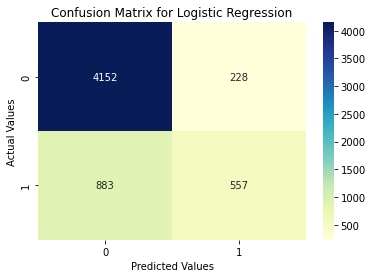

In [29]:
plt.title('Confusion Matrix for Logistic Regression')
cm_lr = confusion_matrix(y_test,pred)
sns.heatmap(cm_lr,annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


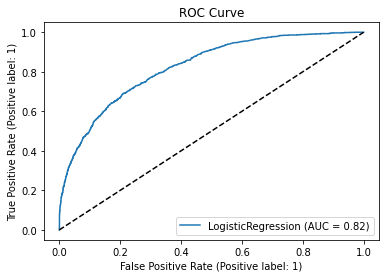

In [30]:
from sklearn.metrics import plot_roc_curve
# Plot ROC curve
plot_roc_curve(logistic_regression, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

In [31]:
print('\nClassification Report of Logistic Regression\n')
print(classification_report(y_test, pred))

print("Precision score of Logistic Regression:", precision_score(y_test, pred, average = 'weighted'))
print("Recall score of Logistic Regression:", recall_score(y_test, pred, average = 'weighted'))
print("F1 score of Logistic Regression:", f1_score(y_test, pred, average = 'weighted'))


Classification Report of Logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4380
           1       0.71      0.39      0.50      1440

    accuracy                           0.81      5820
   macro avg       0.77      0.67      0.69      5820
weighted avg       0.80      0.81      0.79      5820

Precision score of Logistic Regression: 0.7961558211959451
Recall score of Logistic Regression: 0.809106529209622
F1 score of Logistic Regression: 0.7876489398736055


### Adding Categorial Features to the Model

<div>In order to consider the categorical features, we use one hot encoder to transform categorical features to binary variables.</div>

In [32]:
def get_categorical_columns(data, cat_columns=None, fillna=True):
    if cat_columns is None:
        cat_data = data.select_dtypes('category')
    else:
        cat_data = data[cat_columns]

    if fillna:
        for colname, series in cat_data.iteritems():
            if 'Other' not in series.cat.categories:
                series = series.cat.add_categories(['Other'])

            cat_data[colname] = series.fillna('Other')
            
    return cat_data

def features_with_one_hot_encoded_categories(data, cat_columns=None, fillna=True):
    cat_data = get_categorical_columns(data, cat_columns, fillna)
    one_hot_data = pd.get_dummies(cat_data)
    df = pd.concat([data, one_hot_data], axis=1)

    features = [
        'age',
        'education_num',
        'hours_per_week',
        'capital_gain',
        'capital_loss',
    ] + one_hot_data.columns.tolist()

    X = df[features].fillna(0).astype(float)
    y = df[target_column]
    
    return X, y

In [33]:
train_data = data.copy(deep=True)
X3, y3 = features_with_one_hot_encoded_categories(train_data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [34]:
#perform train and test data splits using y and X
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=1)
# confirm we have the right number of train and test data set
print( len(X_train), len(X_test), len(y_train), len(y_test) )

23276 5820 23276 5820


In [35]:
# Standardize data to make models coeficients interpratable. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logistic_regression = LogisticRegression()

# instantiate Logistic Regression model
logistic_regression.fit(X_train, y_train)

# Predict the results
pred = logistic_regression.predict(X_test)

In [36]:
# Calculate and print R^2 and MAE
print( 'R^2:', r2_score(y_test, pred))
print( 'MAE:', mean_absolute_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('\n')

R^2: 0.1556792237442921
MAE: 0.15721649484536082
RMSE: 0.3965053528583956
MSE: 0.15721649484536082




In [37]:
print('\nClassification Report of Logistic Regression\n')
print(classification_report(y_test, pred))

print("Precision score of Logistic Regression:", precision_score(y_test, pred, average = 'weighted'))
print("Recall score of Logistic Regression:", recall_score(y_test, pred, average = 'weighted'))
print("F1 score of Logistic Regression:", f1_score(y_test, pred, average = 'weighted'))


Classification Report of Logistic Regression

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4380
           1       0.73      0.59      0.65      1440

    accuracy                           0.84      5820
   macro avg       0.80      0.76      0.77      5820
weighted avg       0.84      0.84      0.84      5820

Precision score of Logistic Regression: 0.8358198945046201
Recall score of Logistic Regression: 0.8427835051546392
F1 score of Logistic Regression: 0.8368278370301496


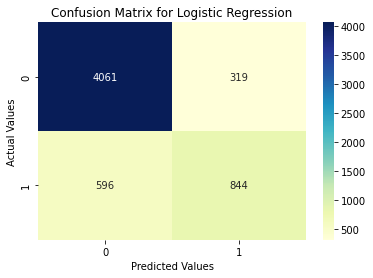

In [38]:
plt.title('Confusion Matrix for Logistic Regression')
cm_lr = confusion_matrix(y_test,pred)
sns.heatmap(cm_lr,annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


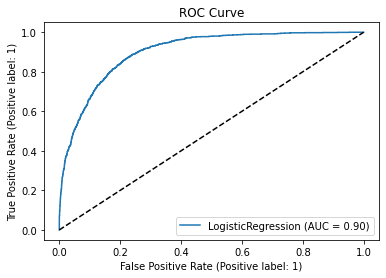

In [39]:
from sklearn.metrics import plot_roc_curve
# Plot ROC curve
plot_roc_curve(logistic_regression, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

## Support Vector Machine

Due to the large number of data points, as well as the number of feaatures, traaining on all of the data would take a significant amount of time (at least from my experience). Therefore, we sample from the the datasets we created for logistic regression. We have an inversely proportional relationship between the sample size and the number of features/parameters we test.

### SVM with 3 features

In [40]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X1.sample(n = 100, replace = False), 
                                                                    y1.sample(n = 100, replace = False), 
                                                                    test_size=0.2, 
                                                                    random_state=1)

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Creating various SVC models to tune the hyperparameters
# Parameters used for hypertuning
parameters = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'degree': [1, 2, 3, 4]}

# Initializes Grid with the classifier used, and the parameters to hypertune
grid = GridSearchCV(SVC(), parameters)

# Trains the models with training data and finds best model
grid.fit(X_train_svm, y_train_svm)

# Hypertuned parameters along with the resulting accuracy
print(grid.best_params_)

{'C': 0.01, 'degree': 1, 'kernel': 'rbf'}


In [45]:
from sklearn.metrics import accuracy_score
y_pred_svm = grid.predict(np.array(X_test_svm))
accuracy_score(y_pred_svm, y_test_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


0.7

In [43]:
# Works if the kernel is linear
importance = grid.best_estimator_.coef_[0]
feature_names = grid.best_estimator_.feature_names_in_
for i,v in enumerate(importance):
    print('Feature: ' + feature_names[i] + ', Score: %.5f' % v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

AttributeError: ignored

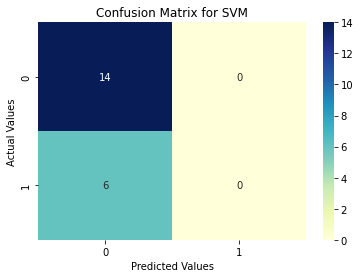

In [46]:
plt.title('Confusion Matrix for SVM')
cm_lr = confusion_matrix(y_test_svm,y_pred_svm)
sns.heatmap(cm_lr,annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### SVM with 5 features

In [47]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X2.sample(n = 100, replace = False), 
                                                                    y2.sample(n = 100, replace = False), 
                                                                    test_size=0.2, 
                                                                    random_state=1)

In [48]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Creating various SVC models to tune the hyperparameters
# Parameters used for hypertuning
parameters = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

# Initializes Grid with the classifier used, and the parameters to hypertune
grid = GridSearchCV(SVC(), parameters)

# Trains the models with training data and finds best model
grid.fit(X_train_svm, y_train_svm)

# Hypertuned parameters along with the resulting accuracy
print(grid.best_params_)

{'C': 1, 'kernel': 'linear'}


In [49]:
from sklearn.metrics import accuracy_score
y_pred_svm = grid.predict(np.array(X_test_svm))
accuracy_score(y_pred_svm, y_test_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


0.75

Feature: age, Score: -0.00103
Feature: education_num, Score: -0.02051
Feature: hours_per_week, Score: 0.03247
Feature: capital_gain, Score: -0.00053
Feature: capital_loss, Score: 0.00000


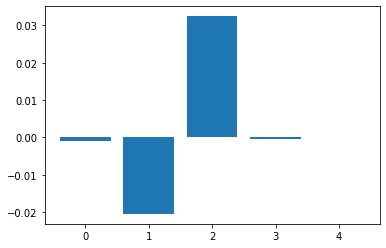

In [50]:
# Works if the kernel is linear
importance = grid.best_estimator_.coef_[0]
feature_names = grid.best_estimator_.feature_names_in_
for i,v in enumerate(importance):
    print('Feature: ' + feature_names[i] + ', Score: %.5f' % v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

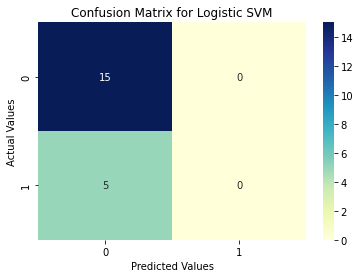

In [51]:
plt.title('Confusion Matrix for Logistic SVM')
cm_lr = confusion_matrix(y_test_svm,y_pred_svm)
sns.heatmap(cm_lr,annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### SVM with Categorial Features

In [52]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X3.sample(n = 50, replace = False), 
                                                                    y3.sample(n = 50, replace = False), 
                                                                    test_size=0.2, 
                                                                    random_state=1)

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Creating various SVC models to tune the hyperparameters
# Parameters used for hypertuning
parameters = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf']}

# Initializes Grid with the classifier used, and the parameters to hypertune
grid = GridSearchCV(SVC(), parameters)

# Trains the models with training data and finds best model
grid.fit(X_train_svm, y_train_svm)

# Hypertuned parameters along with the resulting accuracy
print(grid.best_params_)

{'C': 0.1, 'kernel': 'linear'}


In [54]:
from sklearn.metrics import accuracy_score
y_pred_svm = grid.predict(np.array(X_test_svm))
accuracy_score(y_pred_svm, y_test_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


0.6

Feature: age, Score: -0.00044
Feature: education_num, Score: 0.06043
Feature: hours_per_week, Score: -0.05065
Feature: capital_gain, Score: -0.00012
Feature: capital_loss, Score: 0.00014
Feature: workclass_Federal-gov, Score: 0.00000
Feature: workclass_Local-gov, Score: 0.05385
Feature: workclass_Never-worked, Score: 0.00000
Feature: workclass_Private, Score: -0.10966
Feature: workclass_Self-emp-inc, Score: 0.00000
Feature: workclass_Self-emp-not-inc, Score: -0.04418
Feature: workclass_State-gov, Score: 0.00000
Feature: workclass_Without-pay, Score: 0.00000
Feature: workclass_Other, Score: 0.10000
Feature: education_10th, Score: 0.00000
Feature: education_11th, Score: -0.10000
Feature: education_12th, Score: 0.00000
Feature: education_1st-4th, Score: -0.03636
Feature: education_5th-6th, Score: 0.10000
Feature: education_7th-8th, Score: -0.02640
Feature: education_9th, Score: 0.00000
Feature: education_Assoc-acdm, Score: 0.00000
Feature: education_Assoc-voc, Score: 0.10000
Feature: educ

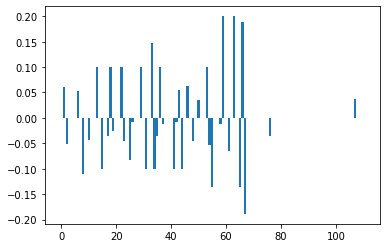

In [55]:
# Works if the kernel is linear
importance = grid.best_estimator_.coef_[0]
feature_names = grid.best_estimator_.feature_names_in_
for i,v in enumerate(importance):
    print('Feature: ' + feature_names[i] + ', Score: %.5f' % v)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

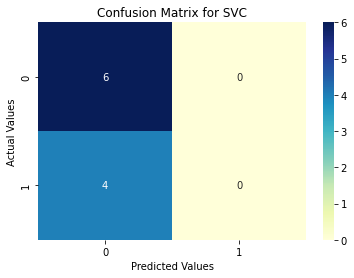

In [56]:
plt.title('Confusion Matrix for SVC')
cm_lr = confusion_matrix(y_test_svm,y_pred_svm)
sns.heatmap(cm_lr,annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()